# Basic demonstration 

In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from rompy.swan import SwanConfig, SwanDataGrid, SwanGrid, SwanModel
from rompy.core import TimeRange
from rompy.swan.data import SwanDataGrid
import xarray as xr
import numpy as np
import tempfile
import os
import pandas as pd
from datetime import datetime
import logging

logging.basicConfig(level=logging.INFO)


In [47]:
SwanModel??

Init signature:
SwanModel(
    *,
    run_id: str = 'run_id',
    period: rompy.core.time.TimeRange = TimeRange(start=datetime.datetime(2020, 2, 21, 4, 0), end=datetime.datetime(2020, 2, 24, 4, 0), duration=datetime.timedelta(days=3), interval=datetime.timedelta(seconds=900), include_end=True),
    output_dir: str = 'simulations',
    config: rompy.swan.config.SwanConfig = {},
    template: str = '/source/rompy/rompy/templates/swan',
    checkout: str = 'main',
    model: str = 'SWAN',
) -> None
Docstring:     
A base class for all models

Parameters
----------

run_id : str
    The run id
period : TimeRange
    The time period to run the model
output_dir : str
    The output directory
config : BaseConfig
    The configuration object
Source:        
class SwanModel(BaseModel):
    config: SwanConfig = {}
    model: str = "SWAN"
    template: str = "/source/rompy/rompy/templates/swan"

    # @property
    # def subnests(self):
    #     """Process subnests for SWAN
    #
    #     Just 

In [48]:
TimeRange??

Init signature:
TimeRange(
    *,
    start: Optional[datetime.datetime] = None,
    end: Optional[datetime.datetime] = None,
    duration: Union[str, datetime.timedelta, NoneType] = None,
    interval: Union[str, datetime.timedelta, NoneType] = '1h',
    include_end: bool = True,
) -> None
Source:        
class TimeRange(RompyBaseModel):
    """A time range object

    Parameters
    ----------
    start : datetime
        The start date of the time range
    end : datetime
        The end date of the time range
    duration : str, timedelta
        The duration of the time range
    interval : str, timedelta
        The frequency of the time range
    include_end : bool

    Examples
    --------
    >>> from rompy import DateTimeRange
    >>> DateTimeRange(start="2020-01-01", end="2020-01-02")
    DateTimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=None, frequency=None)
    >>> DateTimeRange(start="2020-01-01", duration="1d")
  

In [49]:
SwanConfig??

Init signature:
SwanConfig(
    *,
    arg1: str = 'foo',
    arg2: str = 'bar',
    grid: rompy.swan.grid.SwanGrid,
    spectral_resolution: rompy.swan.config.SwanSpectrum = SwanSpectrum(fmin=0.0464, fmax=1.0, nfreqs=31, ndirs=36),
    forcing: rompy.swan.config.ForcingData = ForcingData(bottom=None, wind=None, current=None, boundary=None),
    physics: rompy.swan.config.SwanPhysics = SwanPhysics(friction='MAD', friction_coeff=0.1),
    outputs: rompy.swan.config.Outputs = Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
  115.61 -32.618
  115.686067 -32.532381
)),
    spectra_file: str = 'boundary.spec',
) -> None
Source:        
class SwanConfig(BaseConfig):
    """SWAN configuration

    Parameters
    ----------
    grid : SwanGrid
        Grid for SWAN
    spectral_resolution : SwanSpectrum
        Spectral resolution for SWAN
    forcing : ForcingData
        Forc

In [50]:
from rompy.swan.config import SwanSpectrum, ForcingData, SwanPhysics, Outputs

In [51]:
SwanSpectrum??


Init signature:
SwanSpectrum(
    *,
    fmin: float = 0.0464,
    fmax: float = 1.0,
    nfreqs: int = 31,
    ndirs: int = 36,
) -> None
Source:        
class SwanSpectrum(Spectrum):
    @property
    def cmd(self):
        return f"CIRCLE {self.ndirs} {self.fmin} {self.fmax} {self.nfreqs}"
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [52]:
SwanPhysics??

Init signature: SwanPhysics(*, friction: str = 'MAD', friction_coeff: float = 0.1) -> None
Source:        
class SwanPhysics(RompyBaseModel):
    friction: str = "MAD"
    friction_coeff: float = 0.1

    @validator("friction")
    def validate_friction(cls, v):
        if v not in ["MAD", "OTHER", "ANDANOTHER"]:
            raise ValueError(
                "friction must be one of MAD, OTHER or ANDANOTHER"
            )  # TODO Raf to add actual friction options
        return v

    @validator("friction_coeff")
    def validate_friction_coeff(cls, v):
        # TODO Raf to add sensible friction coeff range
        if float(v) > 1:
            raise ValueError("friction_coeff must be less than 1")
        if float(v) < 0:
            raise ValueError("friction_coeff must be greater than 0")
        return v

    @property
    def cmd(self):
        ret = ""
        ret += f"GEN3 WESTH 0.000075 0.00175\n"
        ret += f"BREAKING\n"
        ret += f"FRICTION {self.friction} {self.fri

In [53]:
ForcingData??

Init signature:
ForcingData(
    *,
    bottom: rompy.swan.data.SwanDataGrid | None = None,
    wind: rompy.swan.data.SwanDataGrid | None = None,
    current: rompy.swan.data.SwanDataGrid | None = None,
    boundary: rompy.swan.data.SwanDataGrid | None = None,
) -> None
Source:        
class ForcingData(RompyBaseModel):
    bottom: SwanDataGrid | None = None  # TODO Raf should probably be required?
    wind: SwanDataGrid | None = None
    current: SwanDataGrid | None = None
    boundary: SwanDataGrid | None = None

    def get(self, grid, runtime):
        ret = []
        for forcing in self:
            if forcing[1]:
                logger.info(f"\t processing {forcing[0]} forcing")
                forcing[1]._filter_grid(grid)
                forcing[1]._filter_time(runtime.period)
                ret.append(forcing[1].get(runtime.staging_dir, grid))
        return "\n".join(ret)

    def __str__(self):
        ret = ""
        for forcing in self:
            if forcing[1]:
      

In [54]:
SwanGrid??

Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    gridtype: Optional[str] = 'REG',
    exc: Optional[float] = None,
    gridfile: Optional[str] = None,
) -> None
Docstring:     
An object which provides an abstract representation of a grid in some geographic space

This is the base class for all Grid objects. The minimum representation of a grid are two
NumPy array's representing the vertices or nodes of some structured or unstructured grid,
its bounding box and a boundary polygon. No knowledge of the grid connectivity is expected.

Parameters
----------
x : numpy.ndarray
    A 1D array of x coordinates
y : numpy.ndarray
    A 1D array of y coordinates
Sour

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

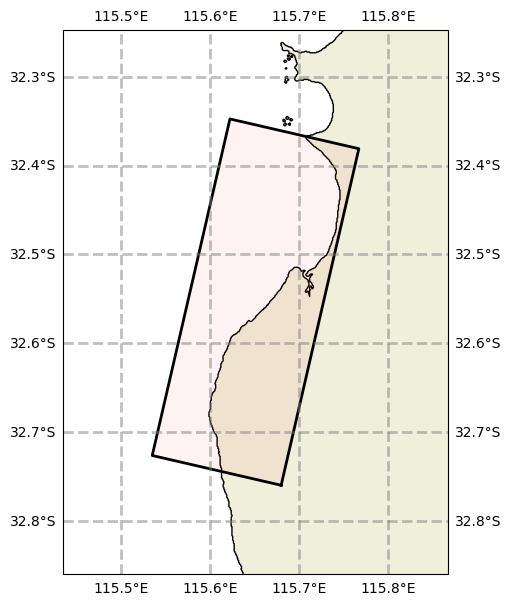

In [55]:
grid = SwanGrid(x0=115.68, y0=-32.76, dx=0.001, dy=0.001, nx=390, ny=150, rot=77)
grid.plot()

In [56]:
SwanDataGrid??

Init signature:
SwanDataGrid(
    *,
    id: str,
    path: Optional[pathlib.Path] = None,
    url: Optional[cloudpathlib.cloudpath.CloudPath] = None,
    catalog: Optional[str] = None,
    dataset: Optional[str] = None,
    args: Optional[dict] = {},
    params: Optional[dict] = {},
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    xarray_kwargs: Optional[dict] = {},
    netcdf_kwargs: Optional[dict] = {'mode': 'w', 'format': 'NETCDF4'},
    z1: str,
    z2: str = None,
    var: str = 'WIND',
) -> None
Source:        
class SwanDataGrid(DataGrid):
    """This class is used to write SWAN data from a dataset.

    Parameters
    ----------
    path: str
            Optional local file path
    url: str
            Optional remote file url
    catalog: str
            Optional intake catalog
 

In [57]:
# Create a dummy netcdf data
os.makedirs("simulations/test_swantemplate/datasets", exist_ok=True)
def nc_bathy():
    # touch temp netcdf file
    bottom = SwanGrid(
        x0=115.68, y0=-32.76, rot=77, nx=391, ny=151, dx=0.001, dy=0.001, exc=-99.0
    )
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "bathy.nc")
    # calculate lat/lon manually due to rounding errors in arange
    lat = []
    for nn in range(bottom.ny):
        lat.append(bottom.y0 + (nn * bottom.dy))
    lon = []
    for nn in range(bottom.nx):
        lon.append(bottom.x0 + (nn * bottom.dx))
    ds = xr.Dataset(
        {
            "depth": xr.DataArray(
                np.random.rand(bottom.ny, bottom.nx),
                dims=["lat", "lon"],
                coords={"lat": lat, "lon": lon},
            ),
        }
    )
    ds.to_netcdf(source)
    return SwanDataGrid(
        id="bottom", path=source, z1="depth", var="BOTTOM", latname="lat", lonname="lon"
    )


def nc_data_source():
    wind_grid = SwanGrid(
        x0=115.68, y0=-32.76, rot=77, nx=391, ny=151, dx=0.001, dy=0.001, exc=-99.0
    )
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "wind_inputs.nc")

    # calculate lat/lon manually due to rounding errors in arange
    lat = []
    for nn in range(wind_grid.ny):
        lat.append(wind_grid.y0 + (nn * wind_grid.dy))
    lon = []
    for nn in range(wind_grid.nx):
        lon.append(wind_grid.x0 + (nn * wind_grid.dx))

    ds = xr.Dataset(
        {
            "u": xr.DataArray(
                np.random.rand(10, wind_grid.ny, wind_grid.nx),
                dims=["time", "lat", "lon"],
                coords={
                    "time": pd.date_range("2000-01-01", periods=10),
                    "lat": lat,
                    "lon": lon,
                },
            ),
            "v": xr.DataArray(
                np.random.rand(10, wind_grid.ny, wind_grid.nx),
                dims=["time", "lat", "lon"],
                coords={
                    "time": pd.date_range("2020-02-21", periods=10),
                    "lat": lat,
                    "lon": lon,
                },
            ),
        }
    )
    ds.to_netcdf(source)
    return SwanDataGrid(id="wind", var="WIND", path=source, z1="u", z2="v")

In [58]:
bathy = nc_bathy()
bathy.plot(param='depth', isel={'time': 0})


PermissionError: [Errno 13] Permission denied: '/source/rompy/notebooks/simulations/test_swantemplate/datasets/bathy.nc'

In [ ]:
# retrive the bathy data
bathy.get('./')

NameError: name 'bathy' is not defined

In [ ]:
# retive the wind data
wind = nc_data_source()
wind.get('./')

INFO:rompy.swan.data:	Writing wind to ./wind.grd


"INPGRID WIND REG 115.68 -32.76 0.0 390 150 0.0010000000000000015 0.0009999999999999905 NONSTATION 20000101.000000 9303.157894736842 HR\nREADINP WIND 1 'wind.grd' 3 0 1 0 FREE\n"

In [ ]:
forcing = ForcingData(wind=wind, bottom=bathy)
forcing.get()

TypeError: ForcingData.get() missing 2 required positional arguments: 'grid' and 'runtime'

In [ ]:
physics = SwanPhysics(friction='INVALID')

ValidationError: 1 validation error for SwanPhysics
friction
  friction must be one of MAD, OTHER or ANDANOTHER (type=value_error)

In [ ]:
physics = SwanPhysics()
print(physics.cmd)

GEN3 WESTH 0.000075 0.00175
BREAKING
FRICTION MAD 0.1

TRIADS

PROP BSBT
NUM ACCUR 0.02 0.02 0.02 95 NONSTAT 20



In [ ]:
outputs??

Object `outputs` not found.


In [ ]:
outputs = Outputs()
outputs
# outputs.cmd

Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
  115.61 -32.618
  115.686067 -32.532381
))

In [ ]:
runtime = SwanModel(
        run_id="test_swantemplate",
        period=TimeRange(start=datetime(2020, 2, 21, 4), end=datetime(2020, 2, 24, 4)),
        output_dir="simulations",
        config=SwanConfig(
            grid=grid,
            physics=physics,
            forcing=forcing,
            outputs=outputs,
        )
    )

In [ ]:
# runtime.config.grid.plot()

In [ ]:
print(runtime.config.forcing.get(grid=runtime.config.grid, runtime=runtime))

INFO:rompy.swan.config:	 processing bottom forcing
INFO:rompy.swan.data:	Writing bottom to simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.config:	 processing wind forcing
INFO:rompy.swan.data:	Writing wind to simulations/test_swantemplate/wind.grd


INPGRID BOTTOM REG 115.68 -32.76 0.0 187 150 0.0009999999999999872 0.0009999999999999905 EXC -99.0
READINP BOTTOM 1.0 'bottom.grd' 3 FREE

INPGRID WIND REG 115.68 -32.76 77.0 389 149 0.001 0.001 NONSTATION 20200222.000000 24.0 HR
READINP WIND 1 'wind.grd' 3 0 1 0 FREE



In [ ]:
runtime.config.outputs.spec.locations

OutputLocs
  115.61 -32.618
  115.686067 -32.532381

In [ ]:
runtime()

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: grid: SwanGrid: REG, 390x150
spectral_resolution: fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: bottom: simulations/test_swantemplate/datasets/bathy.nc
wind: simulations/test_swantemplate/datasets/wind_inputs.nc

physics: friction='MAD' friction_coeff=0.1
outputs: Outputs:
	Grid:
		variables: DEPTH UBOT HSIGN HSWELL DIR TPS TM01 WIND
	Spec
		locations:   115.61 -32.618
  115.686067 -32.532381



template: /source/rompy/rompy/templates/swan

INFO:rompy.core.model:Template used to generate model: /source/rompy/rompy/templates/swan
INFO:rompy.swan.config:	 processing bottom forcing
INFO:rompy.swan.data:	Writing bottom to simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.config:	 pro

'/source/rompy/notebooks/simulations/test_swantemplate'

In [ ]:
runtime.config.forcing.bottom.path

PosixPath('/tmp/tmpoo0h93ku/bathy.nc')